# Credit Risk Prediction
Source link: https://www.kaggle.com/datasets/upadorprofzs/credit-risk<br><br>
I will try to assess the credit risk of a bank's customers. Credit risk is the possible loss of a bank when some of it's customers might not be able to repay their loans, thus causing the bank to lose money. Based on customer data, we can try to predict the possibility of the customers to default (which means the customer decided that they are not be able to repay their loan.)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Read csv data
df = pd.read_csv("original.csv", index_col="clientid")
df

,income,age,loan,default
clientid,,,,
1,66155.925095,59.017015,8106.532131,0
2,34415.153966,48.117153,6564.745018,0
3,57317.170063,63.108049,8020.953296,0
4,42709.534201,45.751972,6103.642260,0
5,66952.688845,18.584336,8770.099235,1
...,...,...,...,...
1996,59221.044874,48.518179,1926.729397,0
1997,69516.127573,23.162104,3503.176156,0
1998,44311.449262,28.017167,5522.786693,1


We have three features and one output variable ("clientid" is the ID of the customer):
<ol>
<li>"income": The income of the customer (in thousands of dollars).</li>
<li>"age": The age of the customer.</li>
<li>"loan": The loan that the customer got from the bank (in thousands of dollars).</li>
<li>"default" (output): Was the customer unable to repay their debt? (1: yes, 0: no)</li>
</ol>
We have 2000 samples in total.

In [3]:
# Only "default" is an int, the other three features are floats.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   income   2000 non-null   float64
 1   age      1997 non-null   float64
 2   loan     2000 non-null   float64
 3   default  2000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 78.1 KB


In [4]:
# We have three missing values in "age".
df.isna().sum()

income     0
age        3
loan       0
default    0
dtype: int64

In [5]:
# Let's remove the three missing rows.
df = df.dropna()
df.isna().sum()

income     0
age        0
loan       0
default    0
dtype: int64

In [6]:
# Below we can see the summary statistics of the dataset.
# The incomes range from $20014.48947 to $69995.685578.
# The loans range from $20014.48947 to $69995.685578.
# There seems to be a mistake in the "age" column as the min value is -52.42328.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
income,1997.0,45333.864334,14325.131177,20014.48947,32804.904487,45788.747100,57787.565659,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,1997.0,4445.487716,3046.792457,1.37763,1936.813257,3977.287432,6440.861434,13766.051239
default,1997.0,0.141713,0.348842,0.00000,0.000000,0.000000,0.000000,1.000000


In [7]:
# We have three customers with negative ages.
df.age.sort_values(ascending=True)

clientid
22     -52.423280
27     -36.496976
16     -28.218361
1753    18.055189
1684    18.055874
          ...    
935     63.885044
1852    63.887141
405     63.924976
943     63.930735
1999    63.971796
Name: age, Length: 1997, dtype: float64

In [8]:
# It was probably a calculating mistake, so we will simply turn them into positive numbers.
pd.options.mode.chained_assignment = None # Turn off SettingwithCopyWarning.
df.age = df.age.apply(lambda x: abs(x))
df.age.sort_values(ascending=True)

clientid
1753    18.055189
1684    18.055874
413     18.075336
46      18.130038
1631    18.176043
          ...    
935     63.885044
1852    63.887141
405     63.924976
943     63.930735
1999    63.971796
Name: age, Length: 1997, dtype: float64

In [9]:
# There are no duplicate rows.
df.duplicated().sum()

0

In [10]:
# The corrected summary statistics table.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
income,1997.0,45333.864334,14325.131177,20014.489470,32804.904487,45788.747100,57787.565659,69995.685578
age,1997.0,40.924874,13.267741,18.055189,29.033679,41.353171,52.587040,63.971796
loan,1997.0,4445.487716,3046.792457,1.377630,1936.813257,3977.287432,6440.861434,13766.051239
default,1997.0,0.141713,0.348842,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
# The correlation graph of the dataset.
# There is a negative correlation between 'age' and 'default'. The lower the age, the higher the default rate.
# There is a positive correlation between 'income' and 'loan'. The higher the income, the higher the loan.
# There is a positive correlation between 'loan' and 'default'. The higher the loan, the higher the default rate.
df.corr()

,income,age,loan,default
income,1.000000,-0.034001,0.441539,0.002222
age,-0.034001,1.000000,0.006440,-0.444908
loan,0.441539,0.006440,1.000000,0.377169
default,0.002222,-0.444908,0.377169,1.000000


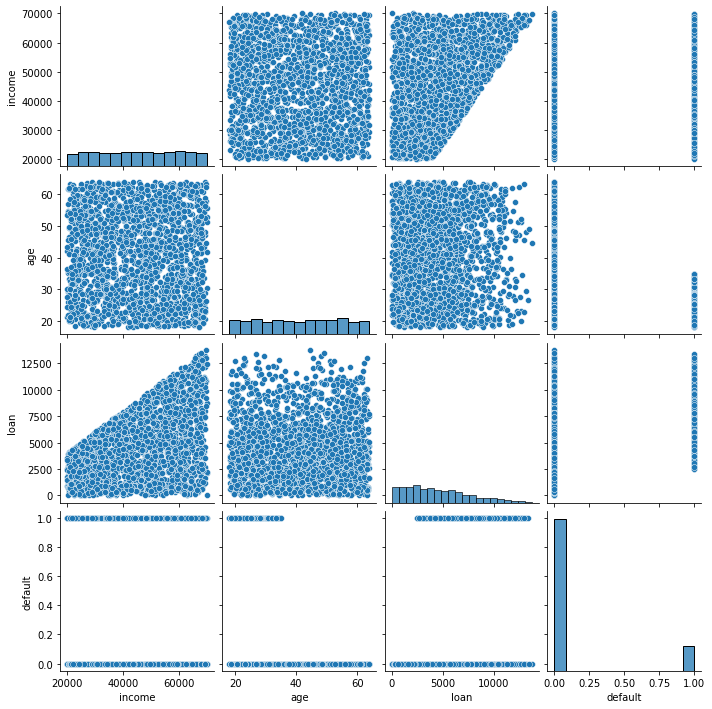

In [12]:
# The pairplot of the dataset.
# We can clearly see a line in 'income'-'loan'.
# We can also see tendencies in 'default'-'age' and in 'default'-'loan'.
sns.pairplot(df)

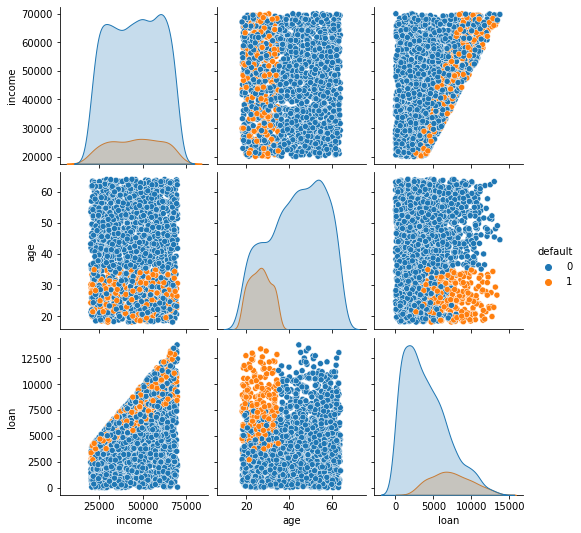

In [13]:
# Pairplot with class hue.
# Again, below we can see interesting patterns in all of the graphs.
sns.pairplot(df, hue='default')

In [14]:
# Let's start with splitting our data into train and test data.
# 1497 samples are used for training, the remaining 500 for testing.
X = df[["income","age","loan"]]
y = df["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Train size: " + str(len(X_train)))
print("Test size: " + str(len(X_test)))

Train size: 1497
Test size: 500


In [15]:
# Normalize the train data, so our algorithms will work better.
# Normalize train and test data seperately, so that no data leakage happens.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.22509016,  0.73172662,  1.18118952],
       [-0.86465241,  0.23183792,  0.24106669],
       [ 1.57735554, -0.47525881, -0.86454116],
       ...,
       [-1.19859855,  1.32007443,  0.3389244 ],
       [-1.32208172,  0.08597074, -0.46035564],
       [-1.46711281, -0.17349276, -0.38435595]])

I have decided to use the following three classification models:
<ol>
<li>LinearSVC</li>
<li>kNN</li>
<li>MLP</li>
</ol>
I use GridSearchCV in all three algorithms in order to tune the hyperparameters. First I define the parameters of the algoirthm, then I initiate the model class, give them both to GridSearchCV as parameters, finally I fit the model and then return the accuracy of the best split.

### 1- SVC

It is a type of support vector machine (SVM). Support vector classifiers (SVC) uses best-fit hyperplanes in order to classify data.<br>
I will test both linear SVC and radial-basis function SVC (which is non-linear).<br>
C is the regularization parameter and is inverse to the strength of regularization.<br>

In [16]:
svc_parameters = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'rbf']
}
svc = SVC()
svc_clf = GridSearchCV(svc, svc_parameters)
svc_clf.fit(X_train, y_train)
svc_accuracy = svc_clf.score(X_test, y_test)
print("Best accuracy: " + str(svc_accuracy))
print("Best parameters: " + str(svc_clf.best_params_))

Best accuracy: 0.998
Best parameters: {'C': 1000, 'kernel': 'rbf'}


### 2- kNN

k-nearest neighbors is a non-parametrical model that doesn't have any training phase, instead it calculates the class of the input data in the prediction phase. Every datapoint is positioned in a space and kNN decides the class of the prediction data based on the classes of the k nearest neighbors.<br>
We will tune the n_neighbors parameter between 1 and 10, and the weights parameters based on 'uniform' (every distance between datapoints is the same) or 'distance' (closer distances between datapoints matter more).

In [17]:
knn_parameters = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, knn_parameters)
knn_clf.fit(X_train, y_train)
knn_accuracy = knn_clf.score(X_test, y_test)
print("Best accuracy: " + str(knn_accuracy))
print("Best parameters: " + str(knn_clf.best_params_))

Best accuracy: 0.98
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


### 3- MLP

Multiplayer perceptron (MLP) is a artificial neural network (ANN). It uses multiple perceptrons to create a network and calculates the classes of input data with weights for every feature (similar to linear regression).<br>
We will tune the parameters of alpha and learning_rate_init.<br>
Alpha is the strength of L2 regularization, meanwhile learning_rate_init is the initial rate of learning.

In [18]:
mlp_parameters = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000) # max_iter increased from default 200 to 2000.
mlp_clf = GridSearchCV(mlp, mlp_parameters)
mlp_clf.fit(X_train, y_train)
mlp_accuracy = mlp_clf.score(X_test, y_test)
print("Best accuracy: " + str(mlp_accuracy))
print("Best parameters: " + str(mlp_clf.best_params_))

Best accuracy: 1.0
Best parameters: {'alpha': 0.001, 'learning_rate_init': 0.01}


### Results

MLP has a perfect accuracy of 100% with the parameters alpha=0.001 and learning_rate_init=0.01.

In [19]:
# Train the best model and get test data labels.
best_clf = MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000, alpha=0.001, learning_rate_init=0.01)
best_clf.fit(X_train, y_train)
X_test_sc = sc.inverse_transform(X_test) # Scale test data back so we can see the original numbers.
best_pred = best_clf.predict(X_test)

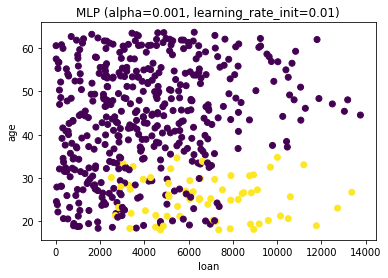

In [20]:
# Scatter plot of the test data.
# 'age' and 'loan' are the two features that matter the most for our classification task.
# Customers below age 35 that borrowed more than $3000 have the highest credit risk.
plt.scatter(x=X_test_sc[:,2], y=X_test_sc[:,1], c=best_pred)
plt.title("MLP (alpha=0.001, learning_rate_init=0.01)")
plt.xlabel('loan')
plt.ylabel('age')
plt.show()

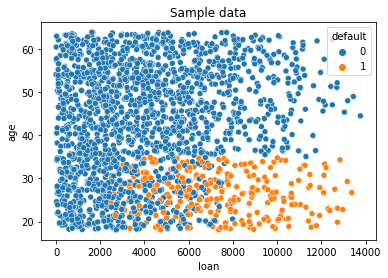

In [21]:
# Scatter plot with every sample. As we can see, both plots share the same pattern.
plt.title("Sample data")
sns.scatterplot(data=X, x="loan", y="age", hue=y)
plt.show()

### Discussion

I initially left the default hidden_layers_size parameter for MLP, however, as it turned out to take very long time to train (dozens of seconds), I decided to reduce the hidden_layers_size. By default, it's a single hidden layer with 100 units, I reduced it to 20 units, which gives us much faster training time and still as much accuracy as with hidden 100 units. However, even with 20 units, the parameter tuning still took much longer (10-15 seconds) compared to the other two models (only a single or two seconds). I tried to reduce the units of MLP even lower, but that made it cause to lose a bit in accuracy. Therefore I picked 20 units for MLP's hidden layer, which gave me the highest accuracy.